# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [3]:
from sklearn import datasets
from pandas import DataFrame

boston_house_prices = datasets.load_boston()

In [4]:
hp = DataFrame(boston_house_prices.data)
hp.columns = boston_house_prices.feature_names
hp['value'] = boston_house_prices.target

In [5]:
hp.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


**Let's make some analysis**

In [6]:
hp_stats = DataFrame()
hp_stats["MIN"] = hp.min()
hp_stats["MAX"] = hp.max()
hp_stats["MEAN"] = hp.mean()
hp_stats.T.applymap(lambda x: round(x, 2))

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,value
MIN,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
MAX,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00
MEAN,3.59,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53


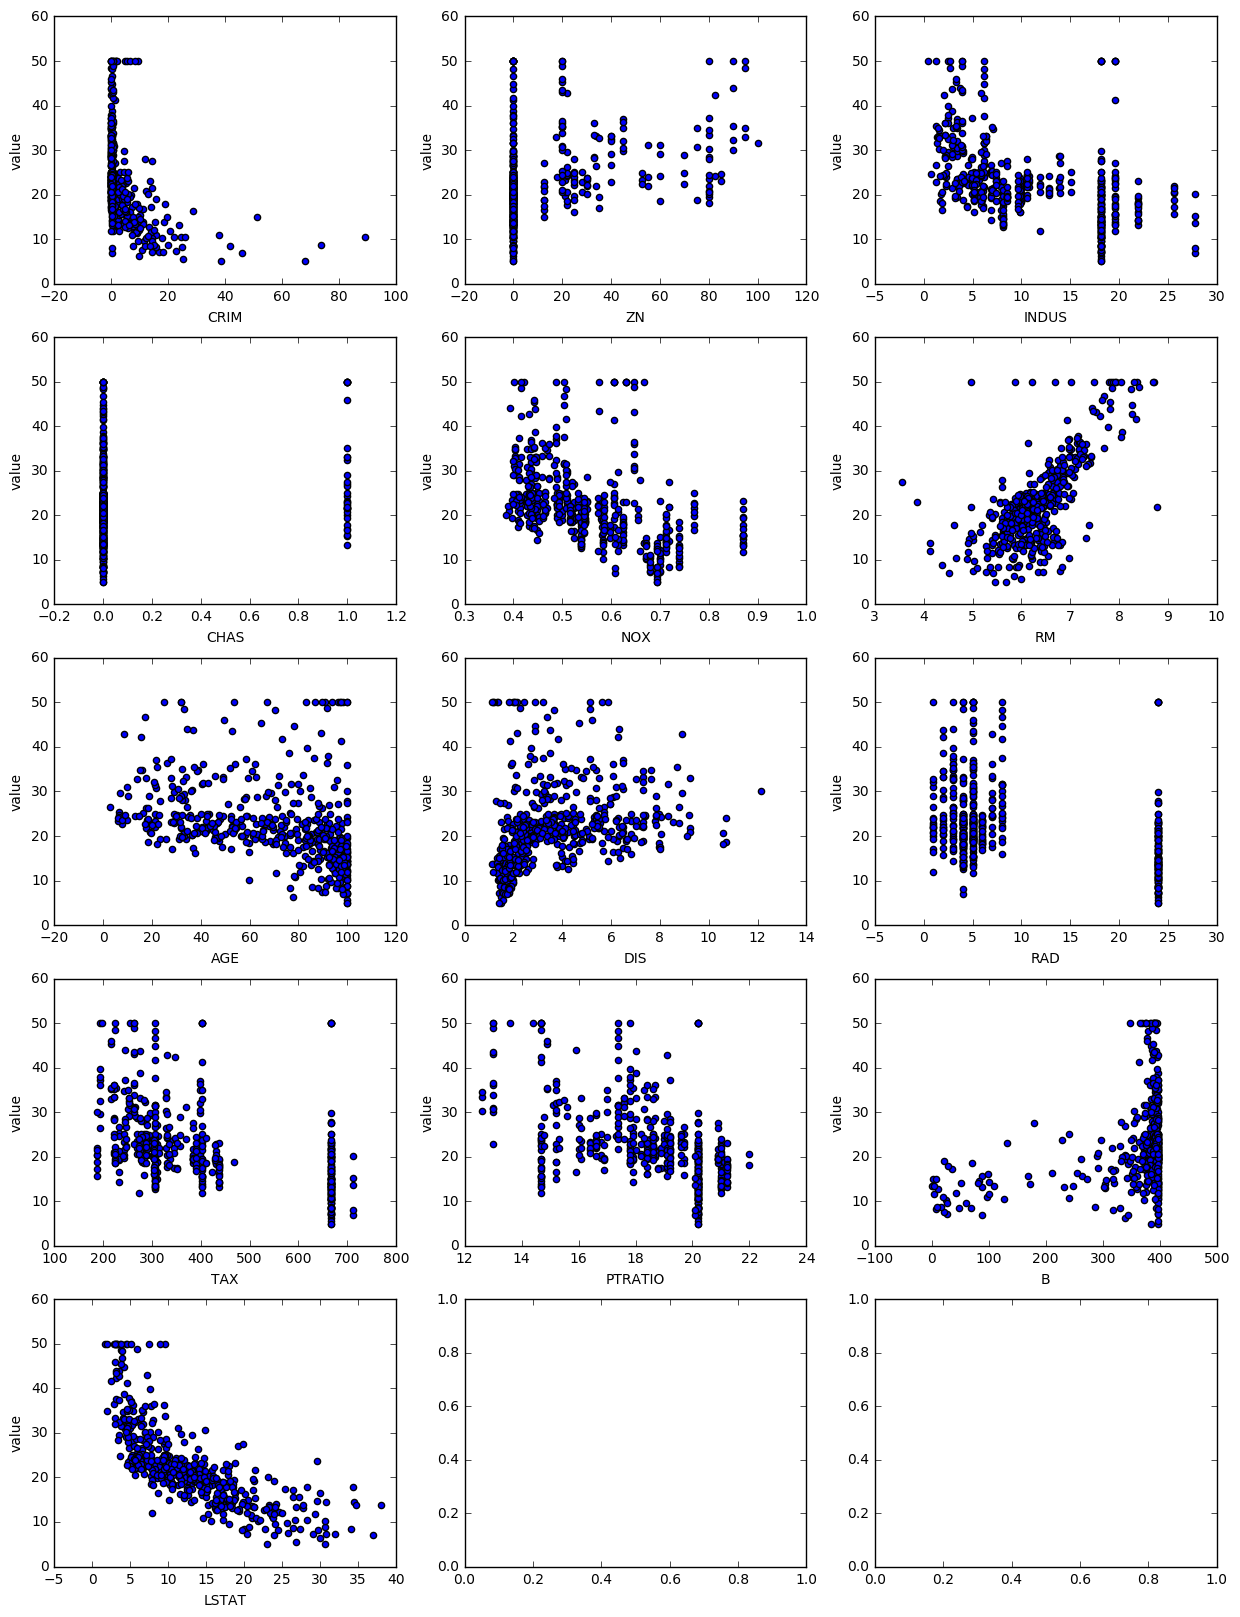

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
for idx, feature in enumerate(hp.columns[:-1]):
    hp.plot(feature, "value", subplots=True, kind="scatter", ax=axes[idx / 3, idx % 3])


**Lets split our data for training and test set**

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

hp_shuffled = shuffle(hp)

X_train = scale(hp_shuffled.iloc[:-120, :-1])
y_train = hp_shuffled.iloc[:-120, -1]

X_test = scale(hp_shuffled.iloc[-120:, :-1])
y_test = hp_shuffled.iloc[-120:, -1]

**Lets try out linear regressor**

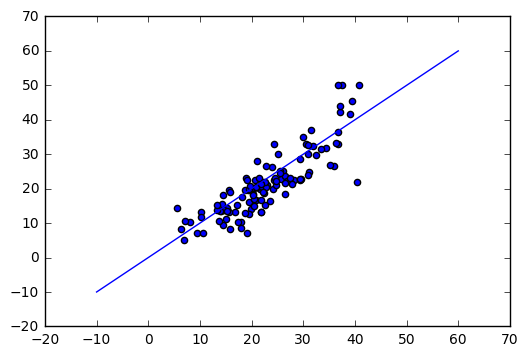

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lr = LinearRegression()
lr.fit(X_train, y_train)

zip(hp.columns, lr.coef_)

plt.scatter(lr.predict(X_test), y_test)
plt.plot([-10, 60], [-10, 60])


In [10]:
metrics.mean_squared_error(lr.predict(X_test), y_test)

25.002465579825646

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [11]:
import numpy as np
def s(y, a_previous):
    return np.subtract(y, a_previous)

#s(y_train, [0] * len(y_train))

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [12]:
from sklearn.tree import DecisionTreeRegressor


def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

base_algorithms_list = []
coefficients_list = []

a = [0.0] * len(y_train)

for i in range(0, 50):
    dtr = DecisionTreeRegressor(max_depth=5, random_state=42)
    dtr.fit(X_train, a)
    base_algorithms_list.append(dtr)
    coefficients_list.append(0.9 / (1.0 + i))
    print metrics.mean_squared_error(gbm_predict(X_test), y_test)
    a = s(y_train, gbm_predict(X_train))

546.167666667
161.333386025
79.0455275193
48.6402002675
35.5423663716
28.3422620269
24.7575132442
22.1454444161
20.3382774797
19.3109265622
18.5118014849
17.8387528167
17.3772340531
17.2389196668
17.0933729986
16.9516956051
16.7863597895
16.7225266706
16.5869355106
16.5308214536
16.5255851195
16.5305427231
16.5140128007
16.494359087
16.539632697
16.5446269243
16.5805229875
16.5866562835
16.62395317
16.6412662713
16.6679701006
16.7141784617
16.7468337917
16.7696462911
16.7849543466
16.8160049255
16.8495419294
16.8747749992
16.8974140244
16.919957979
16.9424278252
16.9649199566
16.982258753
16.9954823326
17.0103500662
17.029783832
17.0492756556
17.0675014664
17.0838445707
17.0884186347


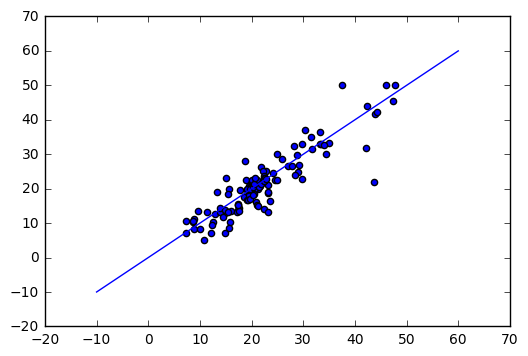

In [24]:
plt.scatter(gbm_predict(X_test), y_test)
plt.plot([-10, 60], [-10, 60])

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 9). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [13]:
import xgboost as xgb

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

metrics.mean_squared_error(gbr.predict(X_test), y_test)
#plt.scatter(lr.predict(X_test), y_test)
#plt.plot([-10, 60], [-10, 60])

15.088324743360772

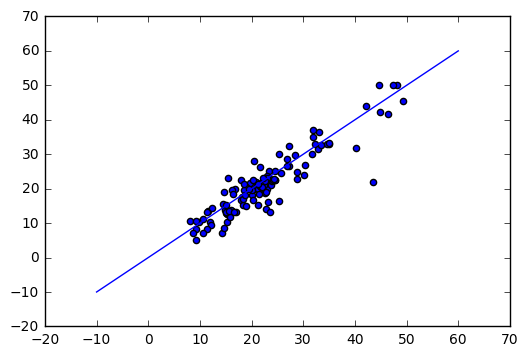

In [25]:
metrics.mean_squared_error(gbr.predict(X_test), y_test)
plt.scatter(gbr.predict(X_test), y_test)
plt.plot([-10, 60], [-10, 60])

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [16]:
import xgboost as xgb

In [30]:
xgbc = xgb.XGBClassifier(max_depth=6, n_estimators=150, learning_rate=0.1).fit(X_train, y_train)


xgbc.predict(X_test)

array([ 25. ,  19.3,  19.1,  24.8,  16.1,  22. ,  50. ,  10.9,  48.3,
        20.6,  10.4,  28.7,  11.7,  29.6,  24.8,  23.3,  35.4,  33.4,
        20.6,  19.3,  50. ,  20.7,  11.7,  20.6,  24.1,  19.4,  10.9,
        14.9,  25. ,   8.3,  20.8,  35.4,  11.7,  20.6,  19.5,  32. ,
        11.7,  12.7,  19.3,   8.3,  20.6,  23.4,  23.1,   7. ,  28.7,
        20.6,  24.8,  22. ,  24.8,  21.4,  20.7,  21.2,  19.5,  34.9,
        20.6,  20.6,  20.6,  50. ,  48.5,  20.6,  15.1,  20.6,  12.7,
        35.4,  23.1,  17.5,  21.9,  22.7,  27.5,  20.6,  20.6,  29. ,
        14.9,  20.8,  33.4,  14.6,  25. ,  21. ,  10.4,  19.1,  25. ,
        29.6,  20.6,  24.1,  20.6,  19.1,  28.7,  21. ,  17.7,  20.6,
        14.6,  11.9,  17.8,  12.7,  24.8,  22. ,  50. ,  17.8,  24.8,
        21.4,   8.8,  14.6,  19.1,  21.7,  22. ,  28.7,  20.6,  20.6,
        27.1,  17.1,  20.6,  17.4,  22.6,  20.6,  25. ,  18.8,  24.8,
        33.4,  25. ,  20.4])

In [31]:
metrics.mean_squared_error(xgbc.predict(X_test), y_test)

39.162916666666661

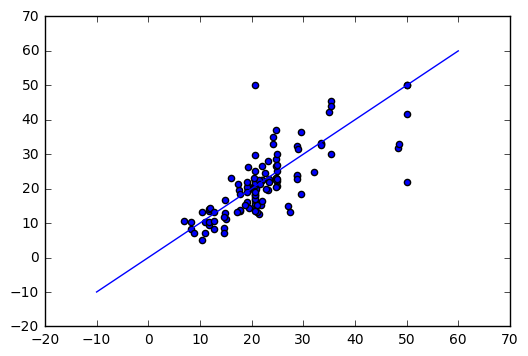

In [32]:
plt.scatter(xgbc.predict(X_test), y_test)
plt.plot([-10, 60], [-10, 60])